** Graphs Synthetic Images Deep Consensus Network - Colaboratory**

In [0]:
%load_ext autoreload
%reload_ext autoreload

In [2]:
import keras
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Activation, AveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.optimizers import RMSprop, Adadelta, Adam, SGD, Adamax, Adagrad
from keras.models import model_from_json

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
# Call the location of the drive
!ls "/content/drive/My Drive/J91"
# Location variables
fname1 = "/content/drive/My Drive/J85/simulated_particles.mrcs"
fname2 = "/content/drive/My Drive/J91/simulated_particles.mrcs"

cryosparc_P11_J91_simulated_particles.cs  job.log  simulated_particles.mrcs


In [5]:
import os
os.chdir("/content/drive/My Drive/DIP/")
!ls mrc.py
import mrc

mrc.py


**Set up Data**

In [0]:
# Define Batch Size and Image size
num=1000  # Bacth Size
n_crop= 380 # Image size (380x380)

particles_hires = mrc.read_imgs(fname1,idx=0,num=num).swapaxes(0,1).swapaxes(0,2)
particles_lowres = mrc.read_imgs(fname2,idx=0,num=num).swapaxes(0,1).swapaxes(0,2)
stack = np.vstack([particles_hires,particles_lowres])

In [7]:
# Print the number of images and the size of each image
print (stack.shape)

(2000, 380, 380)


**Crop Image**

Process to crop image to match n-crop value enter by user

In [0]:
nz,nx,ny=stack.shape
stack = np.vstack([particles_hires,particles_lowres])
stack = stack[:,int(nx/2-n_crop/2):int(nx/2+n_crop/2),int(nx/2-n_crop/2):int(nx/2+n_crop/2)]


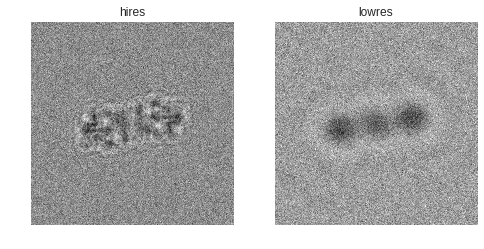

In [9]:
fig = plt.figure()
a = fig.add_subplot(121)
a.set_title('hires')
plt.axis('off')
plt.grid(b=None)
plt.imshow(stack[0],cmap='gray')

a = fig.add_subplot(122)
a.set_title('lowres')
plt.axis('off')
plt.grid(b=None)
plt.imshow(stack[-1],cmap='gray')

In [10]:
# Define initial image and target for training process

o_x_train = stack
o_y_train = np.append(np.zeros(num),np.ones(num))
print (o_x_train.shape)
print (o_y_train.shape)
#np.random.shuffle(o_y_train) # garble labels to check if evaluation accuracy is 50%

(2000, 380, 380)
(2000,)


In [11]:
# The first 1000 images have target value = 0 and the next 1000 images have target = 1
print (o_y_train[990:1000])
print (o_y_train[1050:1100])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [12]:
# Divide data set into training and validation set

x_train, x_val, y_train, y_val = train_test_split(o_x_train, o_y_train,
                                                  test_size=0.1,
                                                  random_state=20) # does random shuffle for us
print (x_train.shape)
print (y_train.shape)

(1800, 380, 380)
(1800,)


In [13]:
# One hot enconding for target values
y_train_targ = pd.get_dummies(y_train)
y_val_targ = pd.get_dummies(y_val)
print (y_val_targ.head(5))


   0.0  1.0
0    0    1
1    0    1
2    0    1
3    0    1
4    1    0


In [14]:
# Create a column vector of image values for the tranining and validation set
x_train = x_train[:,:,:,np.newaxis]
x_val = x_val[:,:,:,np.newaxis]

print('The Training set images have this shape: ' + str(x_train.shape))
print('The Training set labels have this shape: ' + str(y_train_targ.shape))
print('The Validation set images have this shape: ' + str(x_val.shape))
print('The Validation set labels have this shape: ' + str(y_val_targ.shape))

The Training set images have this shape: (1800, 380, 380, 1)
The Training set labels have this shape: (1800, 2)
The Validation set images have this shape: (200, 380, 380, 1)
The Validation set labels have this shape: (200, 2)


In [15]:
#check image shape
x_train[0].shape

(380, 380, 1)

** Build the model**

see the architecture in the Deep Consensus paper (Table 1 in doi:10.1107/S2052252518014392)

note defaults in keras documentation (eg strides=1)

padding='same' to match Deep Consensus Table 1

In [0]:
# Definition of paramaters depending of the number of layers

blocks = 5 # Each block has 5 layers = 2 Conv2D + 1 Activation + 1 Normalization + 1 Pooling

""" k1_size = Kernel size of the first Conv2D layer
    K2_size = Kernel size of the second Conv2D layer
    pool1 = max pooling size
"""


#inputl_kernel = [k1_size,k2_size]
"""Represents the kernel size of the first layer of the network or call input layer"""
inputl_kernel = [15,15]

#inputl_node =  [node1_number, node2_number]
"""Represents the number of node that each CONV2D layer has in the first layer"""
inputl_node = [8,8]

#hiddenl_kernel = [k3_size, k4_size, k5_size,k6_size,...] # Depends on the number of layers
"""Represents the kernel size of the hidden layers of the network"""
hiddenl_kernel = [7, 7, 3, 3]

# hiddenl_node = [node3_number, node4_number, node5_number, node6_number,...] # Depends on the number of layers
"""Represents the number of node that each CONV2D layer has in the hidden layers"""
hiddenl_node = [8,16,32,32]

# pooling_size = [pool1_size, pool2_size, pool3_size, ...] # Depends on the number of layers
"""Represents the size of pooling layer in the input and hidden layer"""
pooling_size = [7,5,3]


# Penultimate Block
# av_pool = [node1_number, node2_number, k1_size, k2_size, av_pool_size]
#average_pool= [64, 64, 3, 3, 4]
n1_ave_pool = 64
n2_ave_pool = 64
k1_ave_pool = 3
k2_ave_pool = 3 
av_pool = 4

# Output Layer = Full connected network
# output_layer = [val_dense, drop]
#output_layer = [512, 0.75]
val_dense = 64
drop = 0.75


In [0]:
# Import py file from google drive 

from customizable_deep_network import build_network

In [18]:
# Build the network
input_shape=x_train.shape[1::] # Define input shape
n_classes = 2
#np.unique(o_y_train.tolist()).size # Define number of classes

# Call function build_network

model = build_network (blocks,input_shape, inputl_node,inputl_kernel,hiddenl_node,
                     hiddenl_kernel, pooling_size, n1_ave_pool, n2_ave_pool, 
                     k1_ave_pool, k2_ave_pool, av_pool, val_dense, drop, n_classes)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
# Print Model Summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 380, 380, 8)       1808      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 380, 380, 8)       14408     
_________________________________________________________________
activation_1 (Activation)    (None, 380, 380, 8)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 380, 380, 8)       32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 190, 190, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 190, 190, 8)       3144      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 190, 190, 16)      6288      
__________

###  Train and Optimizer ###

Define optimizer and train the model

In [0]:
# Different optimizer
# SGD
# RMSprop
# Adagrad
# Adadelta
# Adam
# Adamax

model.compile(optimizer = Adam() , loss='categorical_crossentropy', metrics=['categorical_accuracy'])



In [21]:
# Training Model

%%time
model.fit(x_train, y_train_targ.values, epochs=5, batch_size=int(x_train.shape[0]/100))

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1800/1800 [==============================] - 72s 40ms/step - loss: 0.0205 - categorical_accuracy: 0.9917
Epoch 2/5
1800/1800 [==============================] - 64s 36ms/step - loss: 3.7958e-04 - categorical_accuracy: 1.0000
Epoch 3/5
1800/1800 [==============================] - 64s 36ms/step - loss: 2.3971e-04 - categorical_accuracy: 1.0000
Epoch 4/5
1800/1800 [==============================] - 64s 36ms/step - loss: 3.9109e-04 - categorical_accuracy: 0.9994
Epoch 5/5
1800/1800 [==============================] - 64s 36ms/step - loss: 1.1944e-07 - categorical_accuracy: 1.0000
CPU times: user 2min 40s, sys: 1min 36s, total: 4min 17s
Wall time: 5min 29s


In [22]:
# Validation Process

%%time
scores = model.evaluate(x_val, y_val_targ.values)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

200/200 [==============================] - 4s 21ms/step

categorical_accuracy: 100.00%
CPU times: user 1.77 s, sys: 1.36 s, total: 3.13 s
Wall time: 4.12 s


### Performance Graphs###

**ROC Curves and AUC**

A useful tool when predicting the probability of a binary outcome is the Receiver Operating Characteristic curve

Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0

In [0]:
y_val_targ = np.array(y_val_targ)

In [0]:
from sklearn.metrics import roc_curve
# Making prediction using the model trained above and the validation data set

y_pred = model.predict(x_val)
y_pred = y_pred.astype(int)
fpr_model1, tpr_model1, thresholds_model1 = roc_curve(y_val_targ.argmax(axis=1), y_pred.argmax(axis=1))


In [28]:
from sklearn.metrics import auc
auc_model1 = auc(fpr_model1, tpr_model1)
print('AUC: %.3f' % auc_model1)

AUC: 1.000


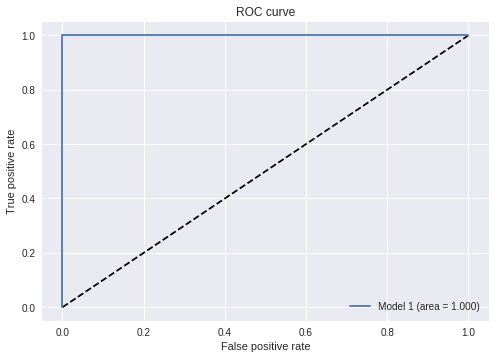

In [29]:
# Plot ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_model1, tpr_model1, label='Model 1 (area = {:.3f})'.format(auc_model1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

**Precision - Recall Curves**

Precision and recall is useful in cases where there is an imbalance in the observations between the two classes. Specifically, there are many examples of no event (class 0) and only a few examples of an event (class 1).

Precision is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.

Recall is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.

In [0]:
# Calculate precision-recall curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score


precision, recall, thresholds = precision_recall_curve(y_val_targ.argmax(axis=1), y_pred.argmax(axis=1))

In [31]:
# Calculate F1 score
f1 = f1_score(y_val_targ.argmax(axis=1), y_pred.argmax(axis=1))

# Calculate precision-recall AUC
auc = auc(recall, precision)

# Calculate average precision score
ap = average_precision_score(y_val_targ.argmax(axis=1), y_pred.argmax(axis=1))
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))

f1=1.000 auc=1.000 ap=1.000


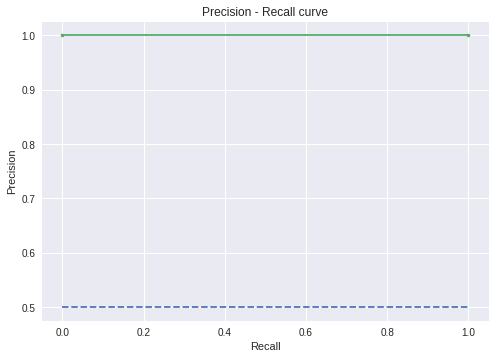

In [32]:
# Plot Curves
# Plot no skill
plt.figure(2)
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# Plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
# Show the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall curve')
#plt.legend(loc='best')
plt.show()


The no-skill line is defined by the total number of positive cases divide by the total number of positive and negative cases. For a dataset with an equal number of positive and negative cases, this is a straight line at 0.5. Points above this line show skill

### Save Neural Network Model and Weights ###

The model and weight data is saved in a local directory. This model can be call in a different notebook or application.  It is important to compile the loaded model before it is used. This is so that predictions made using the model can use the appropriate efficient computation from the Keras backend.

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json) 

TypeError: ignored

In [0]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
